# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (ie 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - 
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="./fig/pic1.png"/>

Then you will want to run the above command:

<img src="./fig/pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import json
import progressbar
from datetime import datetime
from collections import defaultdict

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, recall_score, f1_score

% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

E:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# <span id="0">Purpose of the Project</span>

The project aims to build **machine learning model** to predict two kind of issues, based on his/her demographic information:
1. Is this person an offer-drive customer
2. If 1 is yes, then which kind of offer is effective on him/her 

The offer type is from portfolio dataset:
<img src="./fig/offer_typs.jpg", width="500", height="400"/>

For the first issue, a regression model will be used. The basic concept of the model will be:
- Input:
    - Customer details (gender, age, income)
- Output:
    - Offer-drive degree(0 to 1, 0 means the consumer is totally not influenced by offer or doesn't pay attention to offer while 1 means the customer is completely purchased according to offer)
    
For the second issue, a multi-classification will be used. The basic concept of the model will be:
- Input:
    - Customer details (gender, age, income)
- Output:
    - Effective offer type (With 0 and 1 on type to signal the effectiveness of the offer)

#  Content
#### 1. [Walk through and Clean dataset](#1)
#### 2. [Training model](#2)
#### 3. [Testing model](#3)
#### 4. [Conclusion](#4)

### <span id="1">1. Walk throught and Clean dataset</span>

In [2]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


The offer id is too difficult to remember.
To keep it easy for recognize, add a new column to number each offer

In [3]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
profile.shape

(17000, 5)

In [5]:
# NaN value detection
profile.isna().sum(axis=0)

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [6]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [7]:
# Turn became_member_on data into appropriate format
profile.became_member_on = pd.to_datetime(profile.became_member_on, format = '%Y%m%d')

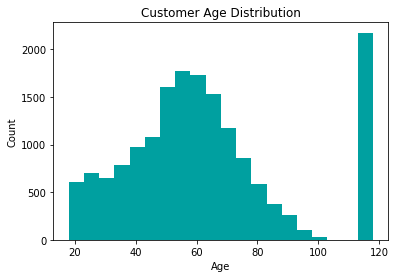

In [8]:
# Age distribution
plt.hist(profile.age, bins = 20, color = '#00A0A0');
plt.xlabel('Age');
plt.ylabel('Count');
plt.title('Customer Age Distribution');

There is quite a lot outliers in age data

In [9]:
profile[profile.age == profile.age.max()].count()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64

In [10]:
profile[profile.age < profile.age.max()].count()

age                 14825
became_member_on    14825
gender              14825
id                  14825
income              14825
dtype: int64

In [11]:
profile.age.max()

118

People with age at 118 seems like to be defaulted by app since all of them have no data in gender or income.
The best way to deal is to remove them from dataset. Since our demographic machine learning can't deal with these customers in either training or testing.

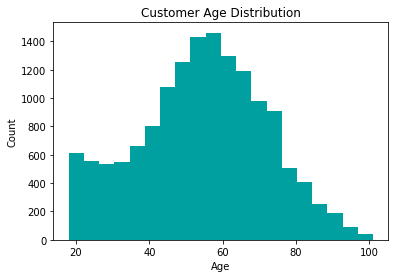

In [12]:
plt.hist(profile[profile.age < 118].age, bins = 20, color = '#00A0A0');
plt.xlabel('Age');
plt.ylabel('Count');
plt.title('Customer Age Distribution');

After remove outliers, the histogram seems reasonable.

In [13]:
# Remove these outliers in another dataset
profile_remove = profile[profile.age == 118]
profile = profile[profile.age < 118].reset_index(drop=True)

In [14]:
profile.duplicated().sum()

0

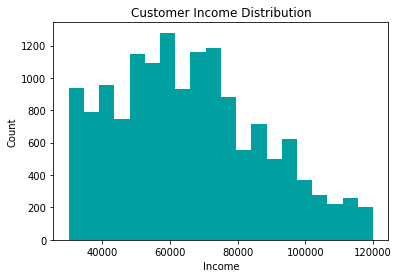

In [15]:
# Income distribution
plt.hist(profile.income, bins = 20, color = '#00A0A0');
plt.xlabel('Income');
plt.ylabel('Count');
plt.title('Customer Income Distribution');

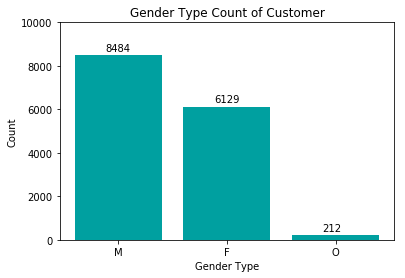

In [16]:
# Look into gender ratio
gender = pd.DataFrame(profile.gender.value_counts())
plt.bar(range(gender.shape[0]), gender.values.reshape(1, -1)[0], color = '#00A0A0');
plt.xticks(range(gender.shape[0]), gender.index);
for i in range(gender.shape[0]):
    plt.text(i-0.12, gender.values.reshape(1, -1)[0][i]+200, gender.values.reshape(1, -1)[0][i]);
plt.ylim(0, 10000);
plt.xlabel('Gender Type');
plt.ylabel('Count');
plt.title('Gender Type Count of Customer');

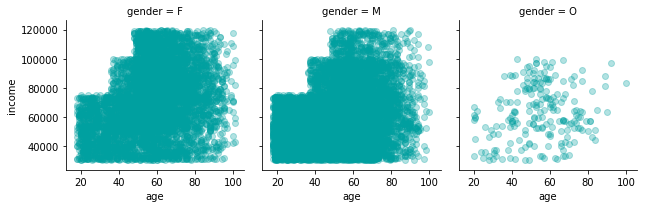

In [17]:
# visualize the 3 factors'(age, income ,gender) relationship
g = sns.FacetGrid(data = profile, col = 'gender');
g.map(plt.scatter, 'age', 'income', alpha=0.3, color = '#00A0A0');
g.add_legend();

There seems to have some pattern of the max and min income for ages. 3 stages have been partitioned. The next step is to find what's the boundary of the age.

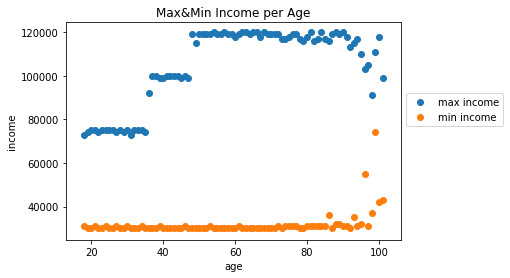

In [18]:
max_income_age = profile.groupby('age').max()
min_income_age = profile.groupby('age').min()
plt.figure(figsize = (6,4))
plt.scatter(max_income_age.index, max_income_age.income);
plt.scatter(min_income_age.index, min_income_age.income);
plt.xlabel('age');
plt.ylabel('income');
plt.title('Max&Min Income per Age')
plt.legend(['max income', 'min income'], bbox_to_anchor=(1.00, 0.5), loc=3);

In [19]:
# find the 2 age boundary that distinguish income range
income_leap = []
for i in range(profile.age.min(), profile.age.max()):
    diff = max_income_age.loc[i+1].income - max_income_age.loc[i].income
    if diff >= 10000:
        income_leap.append(i+1)
    if len(income_leap) == 2:
        break

income_leap

[36, 48]

So it can be concluded that the age can be distributed to 3 groups: from 18 to 35, 36 to 47 and 48+.

In each age group, they share similar income range. It should be presented in features.

In [20]:
profile['young'] = 0
profile['mid_age'] = 0
profile['aged'] = 0

for i in range(profile.shape[0]):
    if profile.loc[i, 'age'] < 36:
        profile.loc[i, 'young'] = 1
    elif profile.loc[i, 'age'] < 48:
        profile.loc[i, 'mid_age'] = 1
    else:
        profile.loc[i, 'aged'] = 1

In [21]:
# get dummy features with gender data and drop original column
profile = pd.concat([profile, pd.get_dummies(profile.gender).iloc[:,:-1]], axis = 1)
profile.drop('gender', axis=1, inplace=True)
profile.head()

,age,became_member_on,id,income,young,mid_age,aged,F,M
0,55,2017-07-15,0610b486422d4921ae7d2bf64640c50b,112000.0,0,0,1,1,0
1,75,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,0,1,1,0
2,68,2018-04-26,e2127556f4f64592b11af22de27a7932,70000.0,0,0,1,0,1
3,65,2018-02-09,389bc3fa690240e798340f5a15918d5c,53000.0,0,0,1,0,1
4,58,2017-11-11,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,0,1,0,1


In [22]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [23]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

The 'value' column is a complicated dict. Simplification is needed for further analysis:
- Rows of event is either 'offer received', 'offer viewed', or 'offer completed' rows will extract offer id in a new added column named 'offer_id'
- Rows of event is 'transaction' will extract the amount figure and in the new 'offer_id' column leave 'NA'

In [24]:
transcript['offer_id'] = 'NA'

In [25]:
rec_and_view = transcript[transcript.event.isin(['offer received', 'offer viewed'])]
complete = transcript[transcript.event == 'offer completed']
transactions = transcript[transcript.event == 'transaction']

In [26]:
rec_and_view.loc[:, 'offer_id'] = rec_and_view.loc[:, 'value'].apply(lambda x: x['offer id'])
rec_and_view.loc[:, 'value'] = 0
complete.loc[:, 'offer_id'] = complete.loc[:, 'value'].apply(lambda x: x['offer_id'])
complete.loc[:, 'value'] = 0
transactions.loc[:, 'value'] = transactions.loc[:, 'value'].apply(lambda x: x['amount'])

E:\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [27]:
transcript = pd.concat([rec_and_view, complete, transactions])
transcript.sort_index(inplace=True)

In [28]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 5 columns):
event       306534 non-null object
person      306534 non-null object
time        306534 non-null int64
value       306534 non-null float64
offer_id    306534 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 14.0+ MB


The next step is to combine the profile and transcript into one table.

The procedure of the cleaning would be:
1. Create a new dataframe. The column includes each offer type, 'amount_with_offer'(transaction made under influence of offer),  'amount_without_offer'(transaction made with no influence of offer) and 'trams_times'(how many times transaction happened in transcript period). The index is profile's personal id
2. Iterate through the id in profile
3. Use person_trans_recs() to pull everyone's personal transaction record
4. Set 1 to the related column, once there is an offer received, offer viewed and offer completed for the same offer with type BOGO or discount
5. Set -1 to the related column, if all offers received, offer viewed are not completed at the end for the same offer with type BOGO or discount
6. Set 1 to the related column, once there is an offer received, offer viewed and transaction happened within valid period of an offer with offer type informational
7. Set -1 to the related column, if all offer received, offer viewed and no transaction happened within valid period of an offer with offer type informational
8. Transaction amount made for 4 and 5 will be added to 'amount_with_offer'
9. Other transaction amount will be added to 'amount_without_offer'
10. A new column named 'offer_drive_tendency' will be added using(plus 0.001 incase both amount number is zero): $ offer\_drive\_tendency = \frac{amount\_with\_offer}{amount\_with\_offer+amount\_without\_offer+0.001}$
11. 2 new columns will be added to profile_trans:
    - 'tot_amount', sum of 'amount_with_offer' and 'amount_without_offer'
    - 'avg_amount', average amount calculated from 'tot_amount' divided by 'trans_times'
12. Combine the new dataframe with profile on the person id key

In [51]:
# step 1
cols = portfolio.id.values
profile_trans = pd.DataFrame(np.nan, index = profile.id.values, columns = cols)

In [52]:
profile_trans.head()

,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,3f207df678b143eea3cee63160fa8bed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5
0610b486422d4921ae7d2bf64640c50b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78afa995795e4d85b5d9ceeca43f5fef,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e2127556f4f64592b11af22de27a7932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
389bc3fa690240e798340f5a15918d5c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2eeac8d8feae4a8cad5a6af0499a211d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
# pull offer id related with type to further deal with step 4 and step 5
bogo_disc_offer_ids = portfolio[portfolio.offer_type.isin(['bogo', 'discount'])].id.values

In [54]:
def timer(start_time=None):
    '''print time consumed for the progress
    INPUT:
        start_time: local date and time at the progress begin, default is None
    
    OUTPUT:
        start_time: If INPUT is None, local date time will be recorded as the start time
    '''
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print(f'\n Time taken: {thour} hours {tmin} minutes and {round(tsec, 2)} seconds.')

In [57]:
# function to pull each customer's transcripts
def get_trans_recs(customer_id):
    '''get personal transaction records in transcript data with personal id from profile data
    INPUT:
        customer_id(str): id from profile id
    
    OUTPUT:
        trans_recs(DataFrame): Personal transaction record
    '''
    trans_recs = transcript[transcript.person == customer_id].reset_index(drop=True)
    return trans_recs

def get_offer_progress(trans_recs, view_ind, portfolio=portfolio):
    '''get the complete producure of an offer if viewed in customer's transcript record
    INPUT:
        trans_recs(DataFrame) - transcript record of particular customer
        view_ind(int) - the index in the trans_recs of where the event 'offer viewed' occur
        portfolio(DataFrame) - portfolio of customers
        
    OUTPUT:
        off_id{str} - offer id
        off_start(int) - the time offer received
        view_start(int) - the time offer viewed
        off_end(int) - the time offer expires
    '''
    
        
    return off_id, off_start, view_start, off_end      

In [60]:
# set up a progress bar
start_time = timer()

cnter = 0
pbar = progressbar.ProgressBar(maxval=profile_trans.shape[0], widgets=[progressbar.Bar('=', '[', ']'), progressbar.Percentage()])
pbar.start()

# step 2
for cus_ind in range(profile_trans.shape[0]):      
    # update progress bar
    cnter+=1 
    pbar.update(cnter)
    
    # step 3 to 7
    cus_id = profile_trans.index[cus_ind]
    trans_recs = get_trans_recs(cus_id) # pull his/her transcripts
    off_view_times = defaultdict(int)
    view_idx = trans_recs[trans_recs.event == 'offer viewed'].index.values # save all offer view event index
        
    if len(view_idx) > 0: # customer has noticed offer
        for view_ind in view_idx:
            off_id = trans_recs.loc[view_ind, 'offer_id'] # store the viewed offer id
            off_hour = int(portfolio[portfolio.id == off_id].duration) * 24 # offer duration hour
            view_start = trans_recs.loc[view_ind, 'time'] # the time customer notice the offer

            receive_row = trans_recs[(trans_recs.offer_id == off_id) & 
                                    (trans_recs.event == 'offer received') & 
                                    (trans_recs.time >= (view_start - off_hour)) & 
                                    (trans_recs.time <= view_start)] # get the offer receive index

            if receive_row.shape[0] > 0: # view time is within the duration of the offer
                receive_ind = receive_row.index[0]
                off_start = trans_recs.loc[receive_ind, 'time']
                off_end = off_start + off_hour
            
                profile_trans.loc[cus_id, off_id] = 0 
                # The offer has been viewed by the customer in the duration, so it has a valid result
                off_view_times[off_id] += 1

                if off_id in bogo_disc_offer_ids: # BOGO or discount case
                    try:
                        comp_ind = trans_recs[(trans_recs.offer_id == off_id) & 
                                            (trans_recs.event == 'offer completed') & 
                                            (trans_recs.time >= view_start) & 
                                            (trans_recs.time <= off_end)].index[0] # get the offer complete index

                        profile_trans.loc[cus_id, off_id] += 1 # viewed and completed the offer
                    except:
                        profile_trans.loc[cus_id, off_id] += 0 # viewed and not completed offer

                else: # Informational case
                    info_trans_idx = trans_recs[(trans_recs.time >= view_start) & 
                                                (trans_recs.time <= off_end) & 
                                                (trans_recs.event == 'transaction')].index.values

                    if len(info_trans_idx) > 0:
                         profile_trans.loc[cus_id, off_id] += 1 # viewed and made transaction during the period                       
                    else:
                        profile_trans.loc[cus_id, off_id] += 0 # viewed and made no transaction during the period
            
    for i in off_view_times.keys():
        # calculate effective rate of the offer on that customer
        profile_trans.loc[cus_id, i] = round(profile_trans.loc[cus_id, i] / off_view_times[i], 2)
        

pbar.finish()
timer(start_time)


 Time taken: 0.0 hours 13.0 minutes and 58.94 seconds.


In [61]:
#For further study, the offer id will be substituted by offer_no 
profile_trans.to_csv('profile_trans_1.csv')

In [62]:
profile_trans = pd.read_csv('profile_trans_1.csv', index_col = 'Unnamed: 0')

In [63]:
profile_trans.head()

,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,3f207df678b143eea3cee63160fa8bed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5
0610b486422d4921ae7d2bf64640c50b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78afa995795e4d85b5d9ceeca43f5fef,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,0.0,NaN
e2127556f4f64592b11af22de27a7932,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,0.0
389bc3fa690240e798340f5a15918d5c,NaN,NaN,NaN,0.5,NaN,NaN,1.0,NaN,0.5,1.0
2eeac8d8feae4a8cad5a6af0499a211d,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN


As the offer has some similarity, it can be found some offer is just the duration extent versio of other.
It can be inferred that if a customer can finish the offer in a shorter duration, he can also complete it with a wider duration.
So if some type offer has an 1 in profile_trans, it will also reasonable to get 1 with its duration extent version or easier version.
On contrast, If a duration extent offer is neglected by customer, the base or harder difficulty offer will also be discarded.

|No.|Type| id | difficulty|reward|duration(days)|note|
|----|----|----|----|----|---|---|
|01|BOGO|ae264e3637204a6fb9bb56bc8210ddfd|10|10|7|02 duration extension|
|02|BOGO|4d5c57ea9a6940dd891ad53e9dbe8da0|10|10|5|No|
|03|BOGO|9b98b8c7a33c4b65b9aebfe6a799e6d9|5|5|7|04 duration extension|
|04|BOGO|f19421c1d4aa40978ebb69ca19b0e20d|5|5|7|No|
|05|DISCOUNT|0b1e1539f2cc45b7b9fa7c272da2e1d7|20|5|10|No|
|06|DISCOUNT|fafdcd668e3743c1bb461111dcafc2a4|10|2|10|07 duration extension|
|07|DISCOUNT|2906b810c7d4411798c6938adc9daaa5|10|2|7|No|
|08|DISCOUNT|2298d6c36e964ae4a3e7e9706d1fb8c2|7|3|7|easier than 07 with better reward|
|09|INFORMATIONAL|3f207df678b143eea3cee63160fa8bed|0|0|4|10 duration extension|
|10|INFORMATIONAL|5a8bc65990b245e5a138643cd4eb9837|0|0|3|No|

The next process of the profile_trans is:
- p_1: if a customer in no.2 offer is 1 and no.1 is nan, set to 1
- p_2: if a customer in no.4 offer is 1 and no.3 is nan, set to 1
- p_3: if a customer in no.7 offer is 1 and either of no.6 or no.8 is nan, set to 1
- p_4: if a customer in no.10 offer is 1 and no.9 is nan, set to 1
- p_5: if a customer in no.1 offer is 0 and no.2 is nan, set to 0
- p_6: if a customer in no.3 offer is 0 and no.4 is nan, set to 0
- p_7: if a customer either no.6 or no.8 offer is 0 and no.7 is nan, set to 0
- p_8: if a customer in no.9 offer is 0 and no.10 is nan, set to 0

In [82]:
p_1 = profile_trans[(profile_trans.loc[:,'ae264e3637204a6fb9bb56bc8210ddfd'].isna()) &
        (profile_trans.loc[:,'4d5c57ea9a6940dd891ad53e9dbe8da0']==1)].index
p_2 = profile_trans[(profile_trans.loc[:,'f19421c1d4aa40978ebb69ca19b0e20d'].isna()) &
        (profile_trans.loc[:,'9b98b8c7a33c4b65b9aebfe6a799e6d9']==1)].index
p_3_1 = profile_trans[(profile_trans.loc[:,'fafdcd668e3743c1bb461111dcafc2a4'].isna()) &
        (profile_trans.loc[:,'2906b810c7d4411798c6938adc9daaa5']==1)].index
p_3_2 = profile_trans[(profile_trans.loc[:,'2298d6c36e964ae4a3e7e9706d1fb8c2'].isna()) &
        (profile_trans.loc[:,'2906b810c7d4411798c6938adc9daaa5']==1)].index
p_4 = profile_trans[(profile_trans.loc[:,'3f207df678b143eea3cee63160fa8bed'].isna()) &
        (profile_trans.loc[:,'5a8bc65990b245e5a138643cd4eb9837']==1)].index
p_5 = profile_trans[(profile_trans.loc[:,'ae264e3637204a6fb9bb56bc8210ddfd']==0) &
        (profile_trans.loc[:,'4d5c57ea9a6940dd891ad53e9dbe8da0'].isna())].index
p_6 = profile_trans[(profile_trans.loc[:,'f19421c1d4aa40978ebb69ca19b0e20d']==0) &
        (profile_trans.loc[:,'9b98b8c7a33c4b65b9aebfe6a799e6d9'].isna())].index
p_7_1 = profile_trans[(profile_trans.loc[:,'fafdcd668e3743c1bb461111dcafc2a4']==0) &
        (profile_trans.loc[:,'2906b810c7d4411798c6938adc9daaa5'].isna())].index
p_7_2 = profile_trans[(profile_trans.loc[:,'2298d6c36e964ae4a3e7e9706d1fb8c2']==0) &
        (profile_trans.loc[:,'2906b810c7d4411798c6938adc9daaa5'].isna())].index
p_8 = profile_trans[(profile_trans.loc[:,'3f207df678b143eea3cee63160fa8bed']==0) &
        (profile_trans.loc[:,'5a8bc65990b245e5a138643cd4eb9837'].isna())].index

In [83]:
profile_trans.loc[p_1,'ae264e3637204a6fb9bb56bc8210ddfd'] = 1
profile_trans.loc[p_2,'f19421c1d4aa40978ebb69ca19b0e20d'] = 1
profile_trans.loc[p_3_1,'fafdcd668e3743c1bb461111dcafc2a4'] = 1
profile_trans.loc[p_3_2,'2298d6c36e964ae4a3e7e9706d1fb8c2'] = 1
profile_trans.loc[p_4,'3f207df678b143eea3cee63160fa8bed'] = 1
profile_trans.loc[p_5,'4d5c57ea9a6940dd891ad53e9dbe8da0'] = 0
profile_trans.loc[p_6,'9b98b8c7a33c4b65b9aebfe6a799e6d9'] = 0
profile_trans.loc[p_7_1,'2906b810c7d4411798c6938adc9daaa5'] = 0
profile_trans.loc[p_7_2,'2906b810c7d4411798c6938adc9daaa5'] = 0
profile_trans.loc[p_8,'5a8bc65990b245e5a138643cd4eb9837'] = 0

In [ ]:
def FunkSVD(profile_trans, latent_features=4, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    profile_trans(pandas DataFrame) - a DataFrame with customer id as rows, offer id as columns, and effectiveness as values
    latent_features(int) - the number of latent features used
    learning_rate(float) - the learning rate 
    iters(int) - the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    movie_mat - (numpy array) a latent feature by movie matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_cus = profile_trans.shape[0]
    n_offer = profile_trans.shape[1]
    num_ratings = np.count_nonzero(~np.isnan(profile_trans))
    
    # initialize the customer and offer matrices with random values
    cus_mat = np.random.rand(n_users, latent_features)
    offer_mat = np.random.rand(latent_features, n_movies)
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # header for running results
    print("Optimizaiton Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):

        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-movie pair
        for i in range(n_users):
            for j in range(n_movies):
                
                # if the rating exists
                if ratings_mat[i, j] > 0:
                    
                    # compute the error as the actual minus the dot product of the user and movie latent features
                    diff = ratings_mat[i, j] - np.dot(user_mat[i, :], movie_mat[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2*diff*movie_mat[k, j])
                        movie_mat[k, j] += learning_rate * (2*diff*user_mat[i, k])

        # print results for iteration
        print("%d \t\t %f" % (iteration+1, sse_accum / num_ratings))
        
    return user_mat, movie_mat 

In [39]:
# step 9
profile = profile.set_index('id')
profile_trans = pd.concat([profile.loc[:, ['age', 'income', 'F', 'M', 'young', 'mid_age', 'aged']], profile_trans], axis=1)
profile_trans.drop(['amount_with_offer', 'amount_without_offer'], axis=1, inplace=True)
profile_trans.columns = ['age', 'income', 'F', 'M', 'young', 'mid_age', 'aged', 'offer_1', 'offer_2', 'offer_3', 'offer_4', 'offer_5', \
                   'offer_6', 'offer_7', 'offer_8', 'offer_9', 'offer_10', 'off_drive_coef']
profile_trans.head()

,age,income,F,M,young,mid_age,aged,offer_1,offer_2,offer_3,offer_4,offer_5,offer_6,offer_7,offer_8,offer_9,offer_10,off_drive_coef
id,,,,,,,,,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,55,112000.0,1,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0000
78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,1,0,0,0,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.5714
e2127556f4f64592b11af22de27a7932,68,70000.0,0,1,0,0,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.3191
389bc3fa690240e798340f5a15918d5c,65,53000.0,0,1,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0000
2eeac8d8feae4a8cad5a6af0499a211d,58,51000.0,0,1,0,0,1,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.7957


In [40]:
profile_trans.offer_1.value_counts()

 0.00    10084
-1.00     2663
 1.00     2038
 0.33       23
-0.33       14
 0.50        2
-0.50        1
Name: offer_1, dtype: int64

### <span id="2">2. Training model</span>

#### 2.1 Classification model


In [41]:
from sklearn.externals import joblib

In [42]:
def effc_train_data(offer_id, profile_trans = profile_trans):
    offer_num = int(offer_id[6:])
    offer_num_data = profile_trans[abs(profile_trans[offer_id]) == 1].iloc[:, [0,1,2,3,4,5,6,(6 + offer_num)]]
    
    return offer_num_data

In [43]:
def do_gird_search(offer_num_data):
    '''
    '''
    X, y = offer_num_data.iloc[:,:-1], offer_num_data.iloc[:,-1]
    clf = RandomForestClassifier()
    
    param_dist = {'n_estimators': [100, 200, 300, 500],
                  'criterion': ['gini', 'entropy'],
                  'max_depth': [5, 7, 10, 15, None],
                  'min_samples_split': [2, 3, 5, 7]
                 }
    
    scoring = {'Precision': 'precision', 'Recall': 'recall', 'F1': 'f1'}
    
    grid_clf = GridSearchCV(clf, param_dist, scoring = scoring, refit = 'F1', cv=5, return_train_score=False)
    grid_clf.fit(X, y)
    
    return grid_clf

In [46]:
grid_clfs = []
model_comp_rate = []

offer_list = profile_trans.columns[7:-1]
start_time = timer()
cnter = 0
pbar = progressbar.ProgressBar(maxval=len(offer_list), widgets=[progressbar.Bar('=', '[', ']'), progressbar.Percentage()])
pbar.start()

for i, offer_num in enumerate(offer_list):
    cnter+=1 
    pbar.update(cnter)
    
    offer_num_data = effc_train_data(offer_num)
    
    grid_clf = do_gird_search(offer_num_data)
    joblib.dump(grid_clf, './clf_best_mdls/clf_'+str(i+1)+'.model')
    grid_clfs.append(grid_clf)
    
    result = pd.DataFrame(grid_clf.cv_results_)
    model_precision = round(int(result[result.rank_test_F1 == 1]['mean_test_Precision'].values[0]*100000)/1000,2)
    model_comp_rate.append(model_precision)

pbar.finish()
timer(start_time)


 Time taken: 1.0 hours 45.0 minutes and 17.41 seconds.


In [47]:
model_comp_rate

[60.68, 60.05, 61.37, 60.51, 59.86, 65.5, 68.57, 64.43, 59.53, 60.16]

In [ ]:
transcript.offer_id

In [ ]:
result.to_csv('result.csv')

In [ ]:
for i in offers:
    

In [ ]:
X1_train, X1_test, y1_train, y1_test = train_test_split(offer_1.iloc[:,:4], offer_1.offer_1, test_size = 0.2)

In [ ]:
clf_1 =SVC(random_state=42)

y1_pred = clf.predict(X1_test)

print(classification_report(y1_test, y1_pred))

In [ ]:
roc_auc_score(y1_test, y1_pred)

In [ ]:
confusion_matrix(y1_test, y1_pred)

In [ ]:
y1_pred[:10]

In [ ]:
def validate(y_test, y_pred):
    '''validate the model prediction effectiveness
    INPUT:
    y_test: y_test dataset
    y_perd: prediction result from 
    '''
    tot_1 = 0
    cor_1 = 0
    
    for i in range(y1_test.shape[0]):
            if y1_test.iloc[i, j] == 1:
                tot_1 += 1
                if y1_pred[i, j] == 1:
                    cor_1 += 1
    print(cor_1 / tot_1)
                    

In [ ]:
validate(y1_test, y1_pred)

In [ ]:
# set up a progress bar
start_time = timer()

cnter = 0
pbar = progressbar.ProgressBar(maxval=profile_trans.shape[0], widgets=[progressbar.Bar('=', '[', ']'), progressbar.Percentage()])
pbar.start()

# step 2
for cus_ind in range(profile_trans.shape[0]):      
    # update progress bar
    cnter+=1 
    pbar.update(cnter)
    
    # step 3 to 7
    cus_id = profile_trans.index[cus_ind]
    trans_recs = get_trans_recs(cus_id) # pull his/her transcripts
    
    if trans_recs.shape[0] == 0: # if there is no record in customer's record, skip the cusotmer
        continue
    
    else:
        trans_idx = trans_recs[trans_recs.event == 'transaction'].index.values # save all transaction event index
        view_idx = trans_recs[trans_recs.event == 'offer viewed'].index.values # save all offer view event index
        
        if len(view_idx) > 0: # customer has noticed offer
            offer_trans_idx = [] # later to store offer related trans

            for view_ind in view_idx:
                off_id = trans_recs.loc[view_ind, 'offer_id'] # store the viewed offer id
                off_hour = int(portfolio[portfolio.id == off_id].duration) * 24 # offer duration hour
                view_start = trans_recs.loc[view_ind, 'time'] # the time customer notice the offer

                try: # If the view time is within the duration of offer
                    receive_ind = trans_recs[(trans_recs.offer_id == off_id) & 
                                         (trans_recs.event == 'offer received') & 
                                         (trans_recs.time >= (view_start - off_hour)) & 
                                         (trans_recs.time <= view_start)].index[0] # get the offer receive index

                    off_start = trans_recs.loc[receive_ind, 'time']
                    off_end = off_start + off_hour

                    if off_id in bogo_disc_offer_ids: # BOGO or discount case
                        try:
                            comp_ind = trans_recs[(trans_recs.offer_id == off_id) & 
                                              (trans_recs.event == 'offer completed') & 
                                              (trans_recs.time >= off_start) & 
                                              (trans_recs.time <= off_end)].index[0] # get the offer complete index

                            for i in range(view_ind + 1, comp_ind):
                                if i in trans_idx:
                                    offer_trans_idx.append(i) # Record related transactions as offer related

                            profile_trans.loc[cus_id, off_id] = 1 # viewed and completed the offer
                        except:
                            profile_trans.loc[cus_id, off_id] = -1 # viewed and not completed offer

                    else: # Informational case
                        info_trans_idx = trans_recs[(trans_recs.time >= view_start) & 
                                                    (trans_recs.time <= off_end) & 
                                                    (trans_recs.event == 'transaction')].index.values
                        
                        if len(info_trans_idx) > 0:
                            offer_trans_idx.extend(info_trans_idx) # record related transactions as offer related
                            profile_trans.loc[cus_id, off_id] = 1 # viewed and made transaction during the period
                        
                        else:
                            profile_trans.loc[cus_id, off_id] = -1 # viewed and made no transaction during the period

                except: # If the view time is out of the duration of offer
                    continue

            offer_trans_idx = list(set(offer_trans_idx))
            not_offer_trans_idx = np.setdiff1d(trans_idx, offer_trans_idx, assume_unique=True)

            # Count the amount of total transaction for offer related and not offer related
            for ind in offer_trans_idx:
                profile_trans.loc[cus_id, 'amount_with_offer'] += trans_recs.loc[ind, 'value']
            for ind in not_offer_trans_idx:
                profile_trans.loc[cus_id, 'amount_without_offer'] += trans_recs.loc[ind, 'value']
        
        else: # customer has never noticed offer
            for ind in trans_idx:
                profile_trans.loc[cus_id, 'amount_with_offer'] += trans_recs.loc[ind, 'value']
        
pbar.finish()
timer(start_time)